In [1]:
#导入库
import torch
import torch.nn as nn
import pandas
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import mnist_data

In [2]:
#构建神经网络类Classifier，继承nn.Module
#分类器
class Classifier(nn.Module):
    def __init__(self):
        #初始化pytorch父类，调用父类的构造函数
        super().__init__()
        
        #定义神经网络层
        self.model = nn.Sequential(
            nn.Linear(784, 200),#784到200的全连接映射，包含所有权重
            nn.LeakyReLU(0.02),#将ReLU用于前一模块的输出
            
            nn.LayerNorm(200),
            
            nn.Linear(200, 10),#200到10个节点的全连接映射，包含所有权重
            nn.Sigmoid()#BCE只能处理0-1的值，LeakyReLU可能输出超范围的值，所以这里用sigmoid
        )
        #创建损失函数
        self.loss_function = nn.BCELoss()
        
        #创建优化器，使用梯度下降
        self.optimiser = torch.optim.Adam(self.parameters())
        

        '''
        optimiser.zero_grad()将计算图中的梯度归零；
        loss.backward()从loss函数中计算网络的梯度；
        optimiser.step()使用梯度更新可学习参数；
        在每次训练网络之前，都要将梯度归零，否则每次计算出的梯度值会累积
        '''
        
        #记录训练进展的计数器和列表，放在构造函数（__init__()）里
        self.counter = 0
        self.progress = []
        
        pass
    
    def forward(self, inputs):
        #直接运行模型
        return self.model(inputs)
        #将输入传递给self.Model()，输出直接返回给调用forward()的函数
        
    """
    总结：
    1.通过继承nn.Module，创建了神经网络类，继承了训练神经网络需要的大部分功能；
    2.定义处理信息的神经网络模块，使用nn.Sequential方法；
    3.定义损失函数和更新可学习参数的优化器；
    4.添加forward()函数，pytorch可以将信息传递给网络。
    """
    
    def train(self, inputs, targets):
        #需要网络的输入值和目标值，才能进行比较和计算损失
        #计算网络的输出值
        outputs = self.forward(inputs)
        #计算损失
        loss = self.loss_function(outputs, targets)
        

        
        #每隔10个训练样本增加一次计数器的值，并将损失值添加进列表的末尾
        self.counter+=1
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())#item()展开单值张量，获取里面的数字
            pass
        
        #每10000次训练后打印计数器的值，以了解进展快慢
        if (self.counter % 10000 == 0):
            print("counter = ", self.counter)
            pass
        
        #使用损失更新网络的链接权重
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()
        
        pass
    
    #将损失值绘图
    def plot_progress(self):
        #将损失值列表progress转换为一个pandas DataFrame，方便绘图
        df = pandas.DataFrame(self.progress, columns=['loss'])
        #使用Plot函数的选项，调整图
        df.plot(ylim=(0, 1.0), figsize=(16,8), alpha=0.1, marker='.',grid=True, yticks=(0, 0.25, 0.5))
        pass
    
    pass


In [3]:
#MnistDataset类的定义
class MnistDataset(Dataset):
    
    def __init__(self, csv_file):
        self.data_df = pandas.read_csv(csv_file, header=None)
        pass
    
    def __len__(self):
        #返回DataFrame的大小
        return len(self.data_df)
    
    def __getitem__(self, index):
        #目标图像（标签）
        label = self.data_df.iloc[index, 0]
        #从第index项中提取一个标签
        target = torch.zeros((10))
        #维度为10的张量target表示预期输出
        target[label] = 1.0
        #除了与标签对应的项是1，其余项都是0（one-hot）
        
        #图像数据，取值范围0-255，标准化为0-1(除以255)
        image_values = torch.FloatTensor(self.data_df.iloc[index, 1:].values)/255.0
        
        #返回标签、图像数据张量及目标张量
        return label, image_values, target
    
    #给类添加一个制图方法
    def plot_image(self, index):
        arr = self.data_df.iloc[index, 1:].values.reshape(28, 28)
        plt.title("label = " + str(self.data_df.iloc[index, 0]))
        plt.imshow(arr, interpolation='none', cmap='Blues')
        pass
    
pass

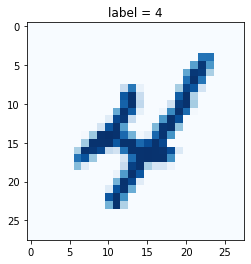

In [4]:
#从类中创建一个数据集对象，并将其CSV文件位置传递给它
mnist_dataset = MnistDataset('mnist_data\mnist_train.csv')
#构造函数将CSV文件中的数据加载到pandas DataFrame里
mnist_dataset.plot_image(9)
#绘出第十幅图

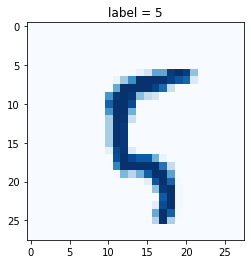

In [5]:
#检查是否可以通过索引访问
mnist_dataset[100]#返回label，像素值和目标张量
mnist_dataset.plot_image(100)

In [6]:
%%time
#记录单元格运行所需时间

#创建神经网络
C = Classifier()

#训练神经网络

epochs = 3

for i in range(epochs):
    print('training epoch', i+1, "of", epochs)
    for label, image_data_tensor, target_tensor in mnist_dataset:
        #mnist_dataset继承了pytorch Dataset，允许使用for循环遍历所有的训练数据
        C.train(image_data_tensor, target_tensor)
        #对于每个样本，将图像数据和目标张量传递给分类器的train()方法
        pass
    pass

training epoch 1 of 3
counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
training epoch 2 of 3
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000
training epoch 3 of 3
counter =  130000
counter =  140000
counter =  150000
counter =  160000
counter =  170000
counter =  180000
Wall time: 5min 5s


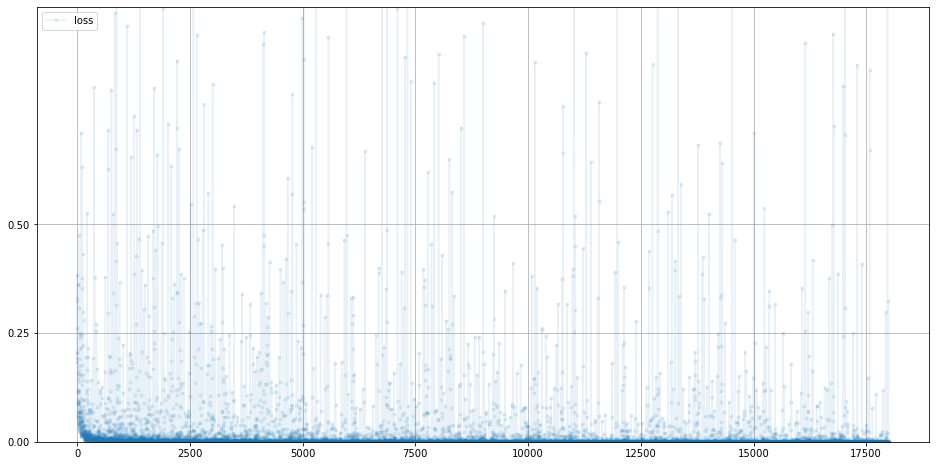

In [7]:
#画出分类器的损失值
C.plot_progress()

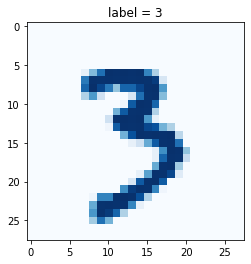

In [8]:
#加载测试数据
mnist_test_dataset = MnistDataset("mnist_data\mnist_test.csv")

#从测试集中挑选一副图像查看
record = 30
#选第20幅=4,第30幅=3
mnist_test_dataset.plot_image(record)
#33号特别潦草，人也很难做出分类

<AxesSubplot:>

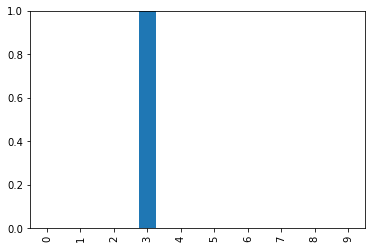

In [9]:
#使用第20幅图像的像素值作为image_data，使用forward()函数将图像送入神经网络
image_data = mnist_test_dataset[record][1]

#调用训练后的神经网络
output = C.forward(image_data)

#绘制张量
pandas.DataFrame(output.detach().numpy()).plot(kind='bar', legend=False, ylim=(0,1))
#像4的概率最高，但也有点像9

In [10]:
#在测试集上的表现
score = 0
items = 0
#score初值为0，在每次输出值与标签匹配时加分

for label, image_data_tensor, target_tensor in mnist_test_dataset:
    answer = C.forward(image_data_tensor).detach().numpy()
    #answer.argmax()输出张量answer中最大值的索引
    if (answer.argmax()==label):
        score += 1
        pass
    items+=1
    
    pass

print(score, items, score/items)

9734 10000 0.9734
